In [1]:
!pip install openpyxl

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [2]:
uploaded = files.upload()  # Upload Online Retail.xlsx
file_path = list(uploaded.keys())[0]

df = pd.read_excel(file_path, engine='openpyxl')

Saving Online Retail.xlsx to Online Retail.xlsx


In [3]:
# Keep only valid rows
df = df.dropna(subset=['InvoiceDate', 'Quantity', 'Description'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]

In [4]:
conn = sqlite3.connect(':memory:')
df.to_sql('retail', conn, index=False, if_exists='replace')

print("📊 Total Records:")
display(pd.read_sql("SELECT COUNT(*) FROM retail", conn))

print("🔍 NULL Check:")
display(pd.read_sql("""
SELECT
  SUM(CASE WHEN InvoiceDate IS NULL THEN 1 ELSE 0 END) AS null_invoicedate,
  SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) AS null_quantity
FROM retail
""", conn))

print("🗓️ Date Range:")
display(pd.read_sql("SELECT MIN(InvoiceDate), MAX(InvoiceDate) FROM retail", conn))

print("🔁 Duplicate Invoices:")
display(pd.read_sql("""
SELECT InvoiceNo, COUNT(*)
FROM retail
GROUP BY InvoiceNo
HAVING COUNT(*) > 1
""", conn))

📊 Total Records:


,COUNT(*)
0,530693


🔍 NULL Check:


,null_invoicedate,null_quantity
0,0,0


🗓️ Date Range:


,MIN(InvoiceDate),MAX(InvoiceDate)
0,2010-12-01 08:26:00,2011-12-09 12:50:00


🔁 Duplicate Invoices:


,InvoiceNo,COUNT(*)
0,536365,7
1,536366,2
2,536367,12
3,536368,4
4,536370,20
...,...,...
18349,581583,2
18350,581584,2
18351,581585,21
18352,581586,4


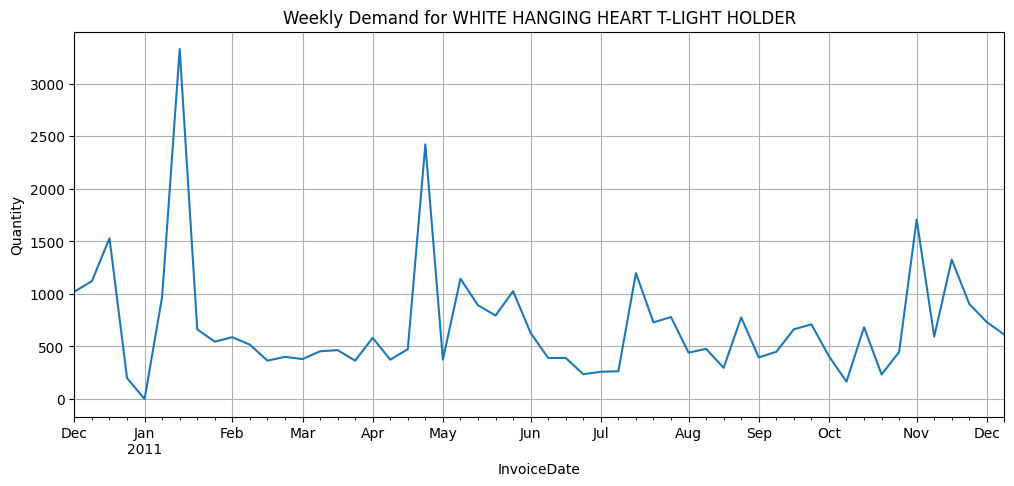

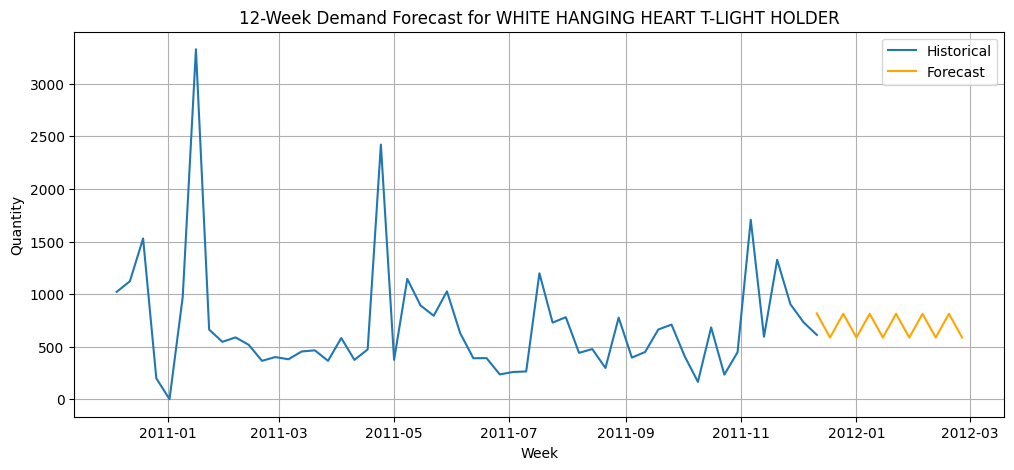

In [5]:
# Focus on one top-selling product
product = df['Description'].value_counts().index[0]
product_df = df[df['Description'] == product]

# Aggregate demand weekly
ts = product_df.groupby('InvoiceDate')['Quantity'].sum().resample('W').sum()
ts = ts.fillna(method='ffill')

# Plot time series
ts.plot(title=f"Weekly Demand for {product}", figsize=(12,5))
plt.grid(True)
plt.ylabel("Quantity")
plt.show()

# Fit ARIMA model (manually specify order)
model = ARIMA(ts, order=(2,1,2))  # ARIMA(p,d,q), tune as needed
model_fit = model.fit()

# Forecast 12 weeks
forecast = model_fit.forecast(steps=12)

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts, label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=12, freq='W'), forecast, label='Forecast', color='orange')
plt.title(f"12-Week Demand Forecast for {product}")
plt.ylabel("Quantity")
plt.xlabel("Week")
plt.grid(True)
plt.legend()
plt.show()